In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

/Users/pasqualinodipilla/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
# Load datasets
ae = pd.read_csv('viralblock-clinical-trial/2_sdtm_R/data/ae_sdtm_sas.csv')
adsl = pd.read_csv('viralblock-clinical-trial/4_adam/data/adsl.csv')

In [7]:
# Convert dates
ae['AESTDTC'] = pd.to_datetime(ae['AESTDTC'])
adsl['TRTSDT'] = pd.to_datetime(adsl['TRTSDT'])

In [8]:
# Take first AE per subject (earliest)
first_ae = ae.sort_values('AESTDTC').drop_duplicates('USUBJID', keep='first')

# Merge with subject-level data
df = adsl.merge(first_ae[['USUBJID', 'AESTDTC']], on='USUBJID', how='left')

# Calculate time to event in days
df['time'] = (df['AESTDTC'] - df['TRTSDT']).dt.days

# Event occurred = 1 if AE observed, 0 otherwise
df['event'] = np.where(df['AESTDTC'].notna(),1,0)

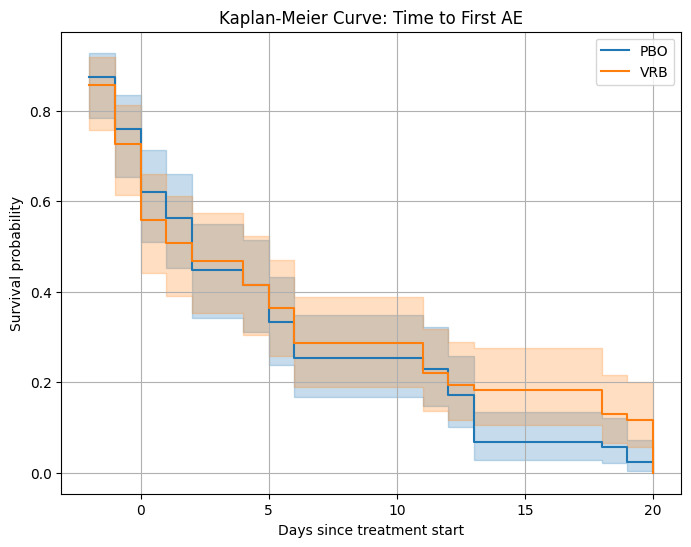

In [9]:
# Kaplan-Meier plot
kmf = KaplanMeierFitter()
# Remove rows with missing time or event values
df_clean = df.dropna(subset=['time', 'event'])

plt.figure(figsize=(8,6))
for treatment in ['PBO', 'VRB']:
    mask = df_clean['ARMCD'] == treatment
    kmf.fit(df_clean.loc[mask, 'time'], df_clean.loc[mask, 'event'], label=treatment)
    kmf.plot_survival_function()
    
plt.title("Kaplan-Meier Curve: Time to First AE")
plt.xlabel("Days since treatment start")
plt.ylabel("Survival probability")
plt.grid(True)
plt.show()

In [10]:
# Log-rank test
p_value = logrank_test(
    df_clean[df_clean['ARMCD']=='PBO']['time'],
    df_clean[df_clean['ARMCD']=='VRB']['time'],
    event_observed_A=df_clean[df_clean['ARMCD']=='PBO']['event'],
    event_observed_B=df_clean[df_clean['ARMCD']=='VRB']['event']
).p_value

<lifelines.CoxPHFitter: fitted with 164 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 164
number of events observed = 164
   partial log-likelihood = -675.29
         time fit was run = 2025-06-04 11:11:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
ARMCD     -0.17      0.84      0.16           -0.48            0.15                0.62                1.16

           cmp to     z    p  -log2(p)
covariate                             
ARMCD        0.00 -1.05 0.29      1.78
---
Concordance = 0.50
Partial AIC = 1352.58
log-likelihood ratio test = 1.12 on 1 df
-log2(p) of ll-ratio test = 1.78

<AxesSubplot: xlabel='log(HR) (95% CI)'>

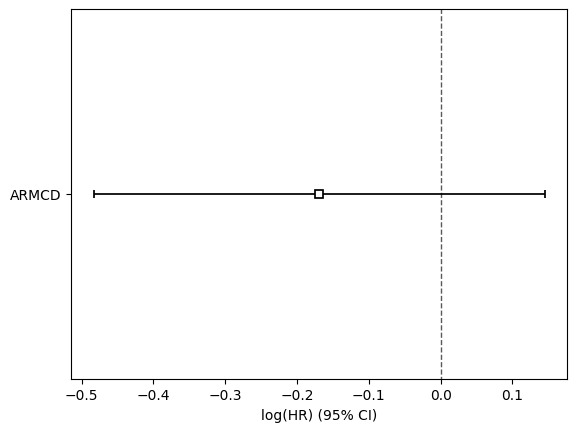

In [14]:
# Cox model
cph = CoxPHFitter()
df_cox = df_clean[['time', 'event', 'ARMCD']].copy()
df_cox['ARMCD'] = df_cox['ARMCD'].map({'PBO': 0, 'VRB': 1})
cph.fit(df_cox, duration_col='time', event_col='event')
cph.print_summary()
cph.plot()

In [16]:
# merge datasets to combine AE events with subject covariates
df2 = ae.merge(adsl[['SUBJID', 'AGE', 'SEX', 'TRTSDT', 'ARMCD']], on='SUBJID')

# Calculate the time to event (duration in days)
df2['duration'] = (df2['AESTDTC']-df2['TRTSDT']).dt.days

# Define the event indicator
# Here, 1 = event occurred (e.g. death or not recovered), 0 = censored
df2['event'] = df2['AEOUT'].apply(lambda x: 1 if x in ['DEATH', 'NOT RECOVERED'] else 0)

# Keep only the necessary columns and drop any rows with missing values
df_cox = df2[['duration', 'event', 'AGE', 'SEX', 'ARMCD']].dropna()

KeyError: "['SUBJID'] not in index"